### Importing Libraries

In [54]:
import cv2
import os
import random,shutil
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from pygame import mixer
from PIL import Image
from keras.models import load_model
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dropout,Conv2D,Flatten,Dense, MaxPooling2D, BatchNormalization
from keras.models import load_model

### Converting video to frames
###### do not run this piece of code (2nd cell) as the frames are already extracted.

In [ ]:
cap = cv2.VideoCapture('1.mp4')
try:
    if not os.path.exists('data'):
        os.makedirs('data')
except OSError:
    print ('Error: Creating directory of data')

currentFrame = 0
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    # Saves image of the current frame in jpg file
    name = './data/frame' + str(currentFrame) + '.jpg'
    print ('Creating...' + name)
    cv2.imwrite(name, frame)
    
    # To stop duplicate images
    currentFrame += 1

### Pre-processing
##### Step 1: Converting images to grayscale
##### Step 2: Resizing the images to 24x24
##### Step 3: Normalizing

In [55]:
def generator(dir, gen = image.ImageDataGenerator(rescale=1./255), shuffle=True,batch_size=1,target_size=(24,24),class_mode='categorical'):
    return gen.flow_from_directory(dir,batch_size=batch_size,shuffle=shuffle,color_mode='grayscale',class_mode=class_mode,target_size=target_size)

In [56]:
Batch_s= 32
Target_s=(24,24)
train_data= generator('train\\',shuffle=True, batch_size=Batch_s,target_size=Target_s)
valid_data= generator('validate\\',shuffle=True, batch_size=Batch_s,target_size=Target_s)
##Value count in each category Open/Closed.
print(train_data)
print(valid_data)

Found 611 images belonging to 2 classes.
Found 618 images belonging to 2 classes.


### CNN Model Training

In [57]:
#Creating model
model = Sequential([
#Conv2D first layer with 32 nodes and kernel of size 3x3
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(24,24,1)),
    MaxPooling2D(pool_size=(1,1)),
#Conv2D second layer with 32 nodes
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(1,1)),
#Conv2D third layer with 64 nodes
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(1,1)),

#Adding Droput layer in order to avoid overfitting
#randomly turn neurons on and off to improve generalisation
    Dropout(0.25),
#flattening over here because there are too many dimesnsions
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

In [58]:
#Calculating steps per epoch and validation steps
epoch_steps= len(train_data.classes)//Batch_s
validate_steps = len(valid_data.classes)//Batch_s

#Compiling the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#Fitting the model
results = model.fit_generator(train_data, validation_data=valid_data,epochs=15,steps_per_epoch=epoch_steps ,validation_steps=validate_steps)
#Saving the model
model.save('drowsiness_model.h5', overwrite=True)

Epoch 1/15
19/19 [==============================] - 17s 907ms/step - loss: 0.4869 - accuracy: 0.7703 - val_loss: 1.0160 - val_accuracy: 0.6250
Epoch 2/15
19/19 [==============================] - 6s 297ms/step - loss: 0.1886 - accuracy: 0.9206 - val_loss: 0.5194 - val_accuracy: 0.7304
Epoch 3/15
19/19 [==============================] - 6s 318ms/step - loss: 0.0803 - accuracy: 0.9689 - val_loss: 0.1835 - val_accuracy: 0.8618
Epoch 4/15
19/19 [==============================] - 5s 252ms/step - loss: 0.0832 - accuracy: 0.9672 - val_loss: 0.2679 - val_accuracy: 0.8242
Epoch 5/15
19/19 [==============================] - 5s 244ms/step - loss: 0.0474 - accuracy: 0.9775 - val_loss: 0.1933 - val_accuracy: 0.9249 loss: 0.0372 - accura
Epoch 6/15
19/19 [==============================] - 5s 246ms/step - loss: 0.0256 - accuracy: 0.9914 - val_loss: 0.2080 - val_accuracy: 0.8840
Epoch 7/15
19/19 [==============================] - 5s 243ms/step - loss: 0.0361 - accuracy: 0.9879 - val_loss: 1.2519 - val_

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 22, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 64)       

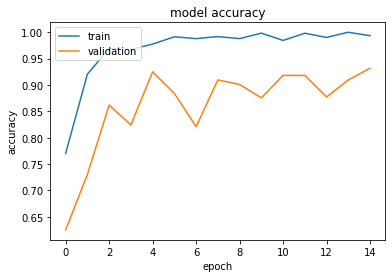

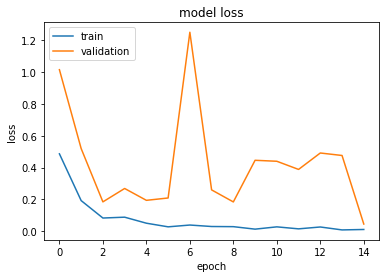

In [60]:
#Plotting the results

#Model Accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#Model loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Model Testing and Drowsiness Detection

In [49]:
#Labels Open and closed
label=['Close','Open']

#Loading the saved model
model = load_model('cnncat2.h5')

path = os.getcwd()
cap = cv2.VideoCapture(0)
font = cv2.FONT_HERSHEY_COMPLEX_SMALL
count=0
score=0
thicc=2
rpred=[99]
lpred=[99]

In [50]:
mixer.init()
sound = mixer.Sound('alarm.wav')

In [51]:
#Haar cascade files 
face = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
leye = cv2.CascadeClassifier('haarcascade_lefteye_2splits.xml')
reye = cv2.CascadeClassifier('haarcascade_righteye_2splits.xml')

In [52]:
while(True):
    ret, frame = cap.read()
    height,width = frame.shape[:2] 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Detecing left and right eye
    faces = face.detectMultiScale(gray,minNeighbors=5,scaleFactor=1.1,minSize=(25,25))
    left_eye = leye.detectMultiScale(gray)
    right_eye =  reye.detectMultiScale(gray)
    cv2.rectangle(frame, (0,height-50) , (200,height) , (0,0,0) , thickness=cv2.FILLED)
    #Detecting the face and framing with a rectangle
    for (x,y,w,h) in faces:
        cv2.rectangle(frame, (x,y) , (x+w,y+h) , (100,100,100) , 1 )
    for (x,y,w,h) in right_eye:
        r_eye=frame[y:y+h,x:x+w]
        count=count+1
        #Converting right eye image to grayscale 
        r_eye = cv2.cvtColor(r_eye,cv2.COLOR_BGR2GRAY)
        #Resizing right eye
        r_eye = cv2.resize(r_eye,(24,24))
        #Normalising right eye
        r_eye= r_eye/255
        r_eye=  r_eye.reshape(24,24,-1)
        r_eye = np.expand_dims(r_eye,axis=0)
        rpred = model.predict_classes(r_eye)
        #Assigning a label as open and closed as 1 and 0 respectively
        if(rpred[0]==1):
            label='Open' 
        if(rpred[0]==0):
            label='Closed'
        break

    for (x,y,w,h) in left_eye:
        l_eye=frame[y:y+h,x:x+w]
        count=count+1
        #Converting right eye image to grayscale 
        l_eye = cv2.cvtColor(l_eye,cv2.COLOR_BGR2GRAY)  
        #Resizing right eye
        l_eye = cv2.resize(l_eye,(24,24))
        #Normalising right eye
        l_eye= l_eye/255
        l_eye=l_eye.reshape(24,24,-1)
        l_eye = np.expand_dims(l_eye,axis=0)
        lpred = model.predict_classes(l_eye)
        #Assigning a label as open and closed as 1 and 0 respectively
        if(lpred[0]==1):
            label='Open'   
        if(lpred[0]==0):
            label='Closed'
        break

    #Scoring Logic
    if(rpred[0]==0 and lpred[0]==0):
        #Keeping a count of the opening and closing of eyes and increasing or decreasing the score accordingly. 
        score=score+1
        cv2.putText(frame,"Closed",(10,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
    else:
        score=score-1
        cv2.putText(frame,"Open",(10,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
    
        
    if(score<0):
        score=0   
    cv2.putText(frame,'Score:'+str(score),(100,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
    if(score>15):
        #person is feeling sleepy so we beep the alarm
        cv2.imwrite(os.path.join(path,'image.jpg'),frame)
        try:
            sound.play()
            
        except:  # isplaying = False
            pass
        if(thicc<16):
            thicc= thicc+2
        else:
            thicc=thicc-2
            if(thicc<2):
                thicc=2
        cv2.rectangle(frame,(0,0),(width,height),(0,0,255),thicc) 
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

KeyboardInterrupt: 

In [53]:
cap.release()
cv2.destroyAllWindows()